https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html

__TODO__

- [x] plot clusters
- [x] gap statistics
- [X] fig style
- [ ] add figure axes labels
- [ ] edit colors for confidence ellipse and mapview land facecolor
- [ ] consider separating plotting functions from stat functions
- [ ] def reduced_chi
- [ ] Euler pole clustering (update HAC opt.)
- [ ] Add more of those info boxes, with explanations from Simpson et al., Savage et al., Thatcher et al.,...
- [ ] style sheet does not apply to cartopy; make the necessary additions

In [1]:
import os
import sys
import math
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import sklearn
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
#sns.set_context("poster")
#sns.set(rc={"figure.figsize": (16, 9.)})
#sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

import geopandas as gpd

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

from gps_cluster.stats import *
from gps_cluster.preprocess import *
from scipy.cluster.hierarchy import dendrogram, linkage

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# 1. Load the data

In [86]:
df=pd.read_csv('../data/raw/SFbay_nafixed_velocity_file.csv', 
    delim_whitespace=True, header=0)

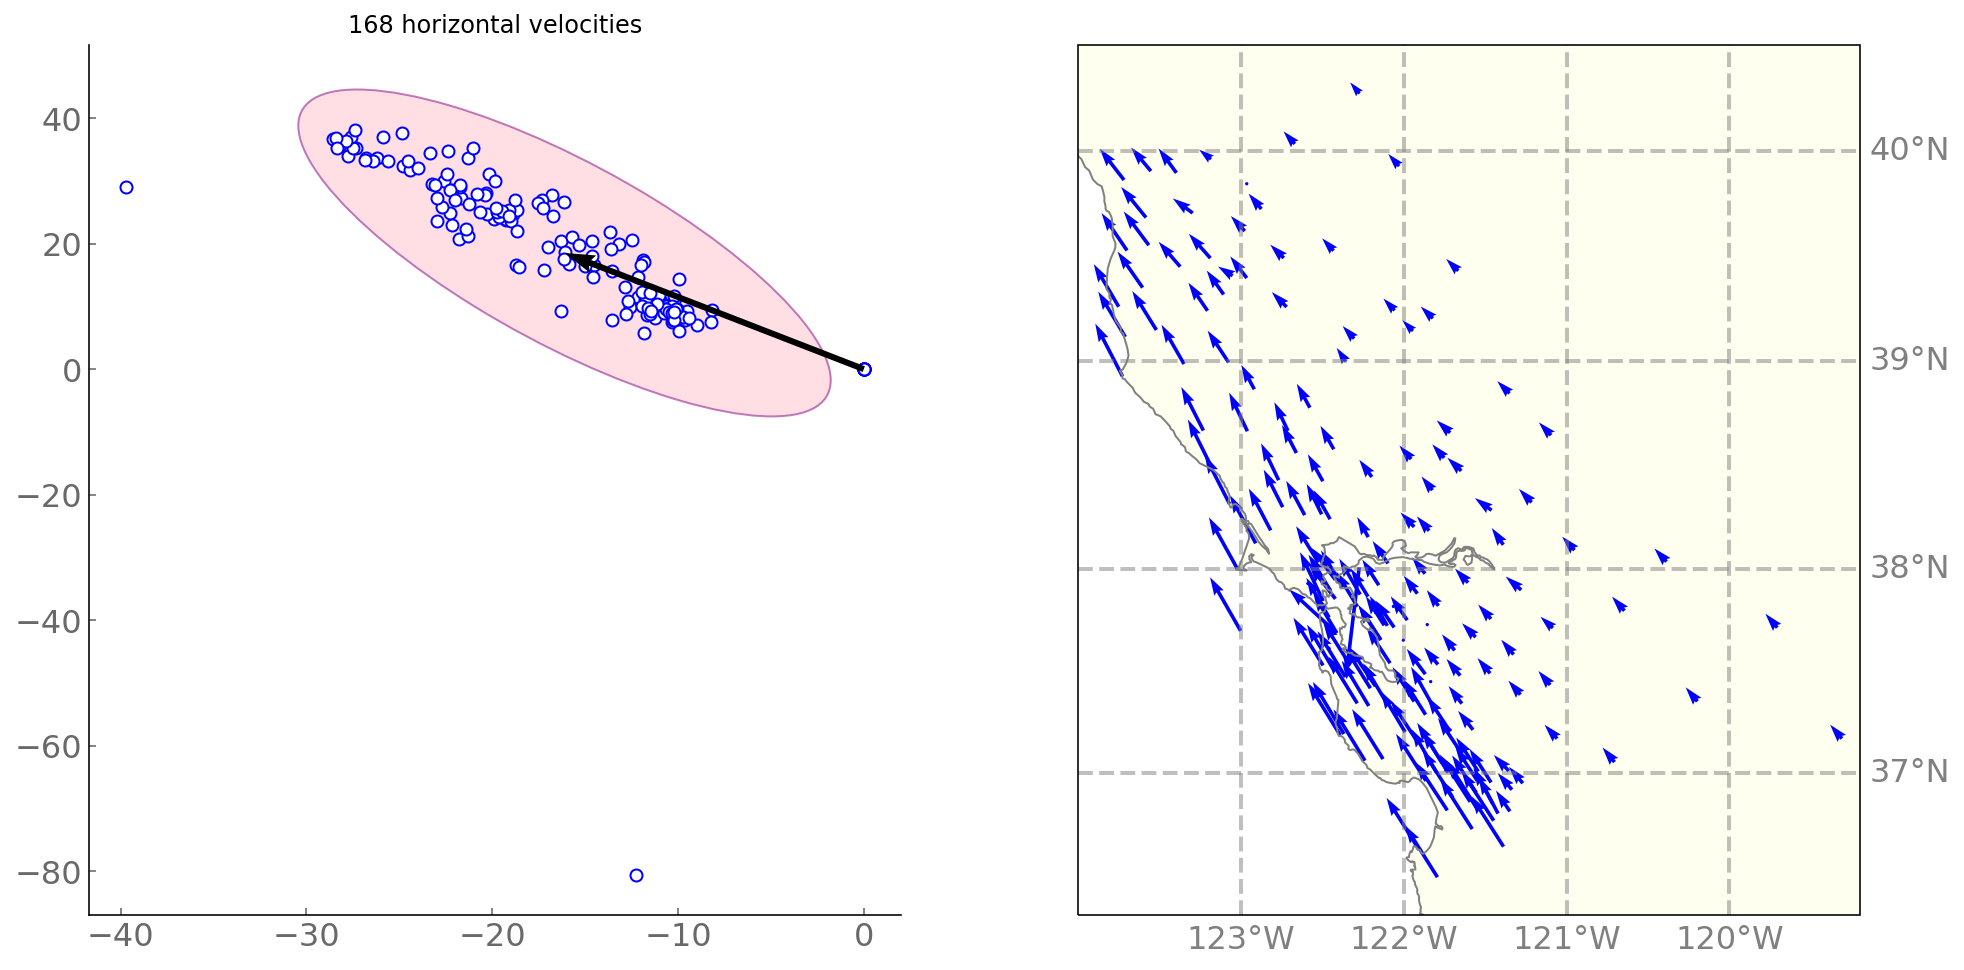

In [87]:
plot_velo_map(df['Longitude'], df['Latitude'], df['Ve'], df['Vn'])

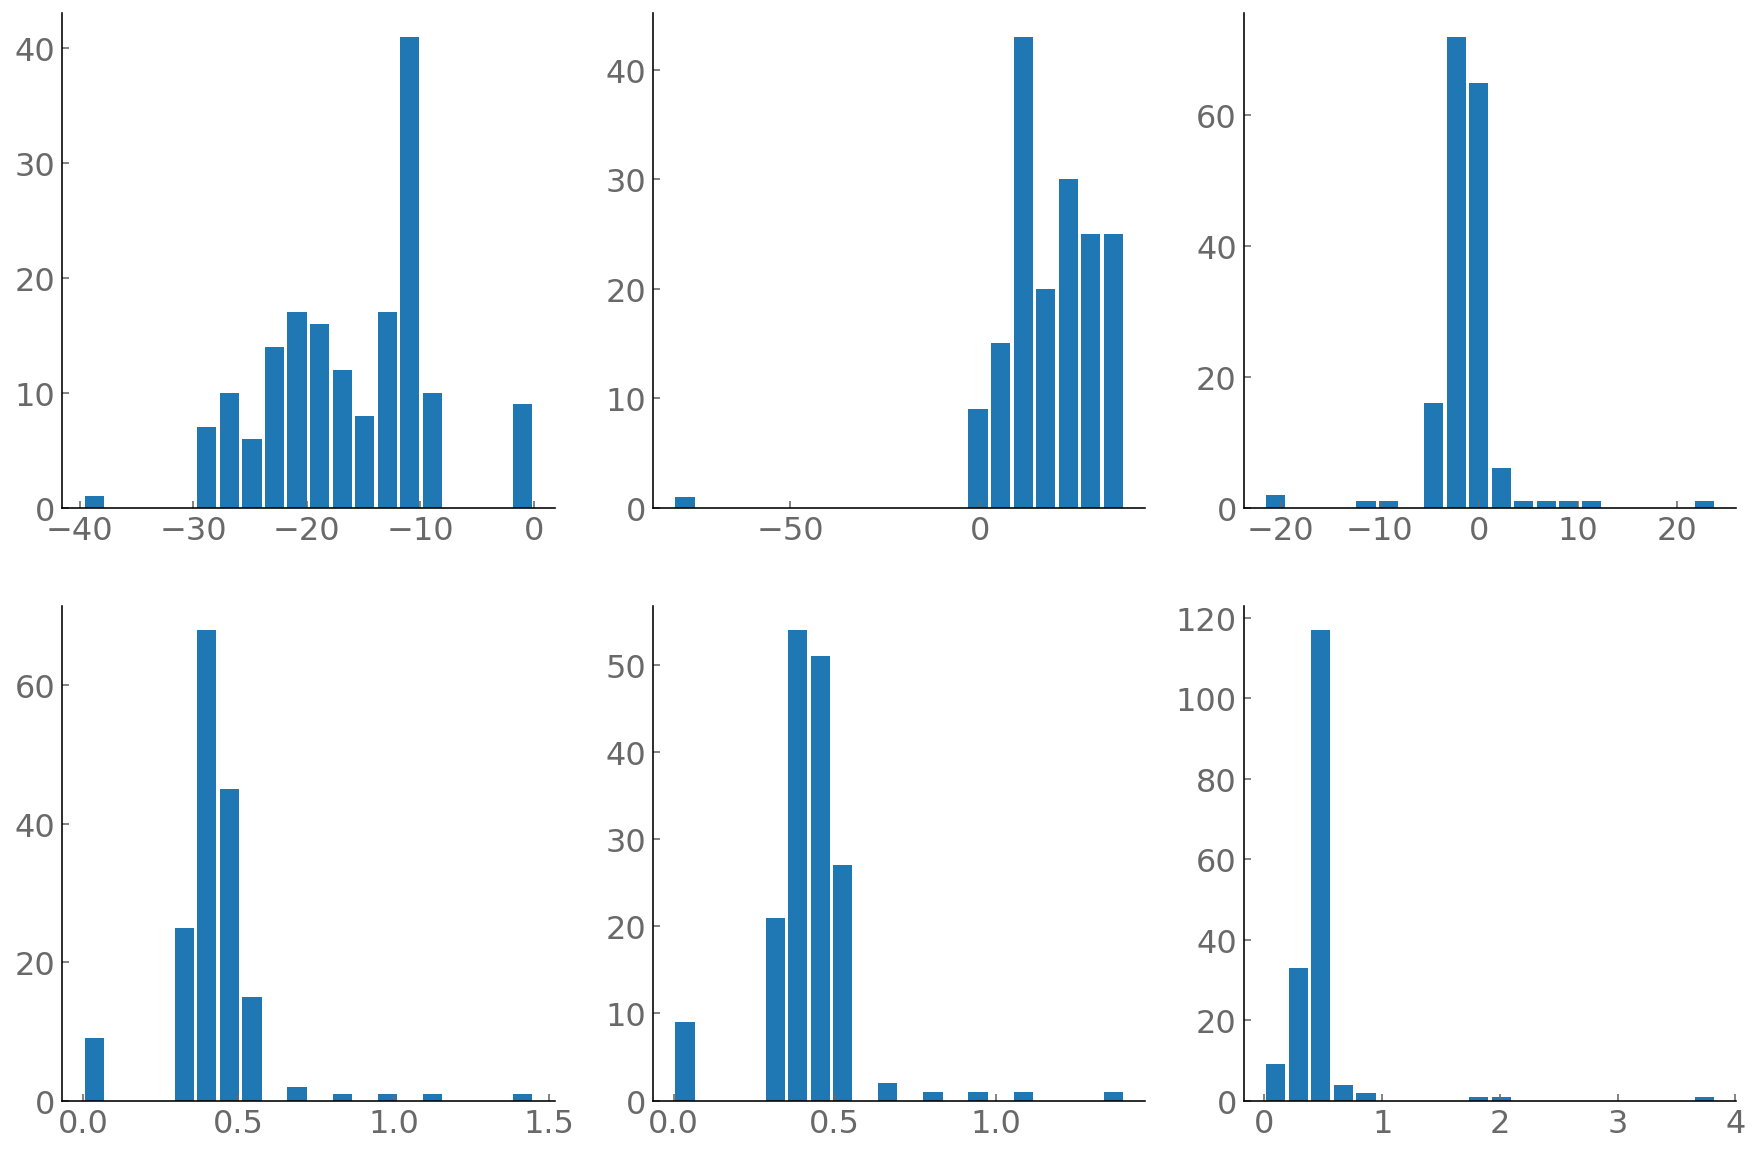

In [88]:
# histograms
fig, ax = plt.subplots(2, 3 , figsize=(15,10))
ax=ax.flatten()

ax[0].hist(df['Ve'], bins=20, rwidth=.85);
ax[1].hist(df['Vn'], bins=20, rwidth=.85);
ax[2].hist(df['Vu'], bins=20, rwidth=.85);
ax[3].hist(df['Se'], bins=20, rwidth=.85);
ax[4].hist(df['Sn'], bins=20, rwidth=.85);
ax[5].hist(df['Su'], bins=20, rwidth=.85);

# after cleaningt
#ax[0].hist(df_['Ve'], bins=20, rwidth=.85);
#ax[1].hist(df_['Vn'], bins=20, rwidth=.85);
#ax[2].hist(df_['Vu'], bins=20, rwidth=.85);
#ax[3].hist(df_['Se'], bins=20, rwidth=.85);
#ax[4].hist(df_['Sn'], bins=20, rwidth=.85);
#ax[5].hist(df_['Su'], bins=20, rwidth=.85);

# 2. Cleaning and vis.

In [89]:
# After data cleaning
df_ = (df.pipe(remove_fixed)
         .pipe(remove_uncertain)
         .pipe(remove_outliers, 2)
      )

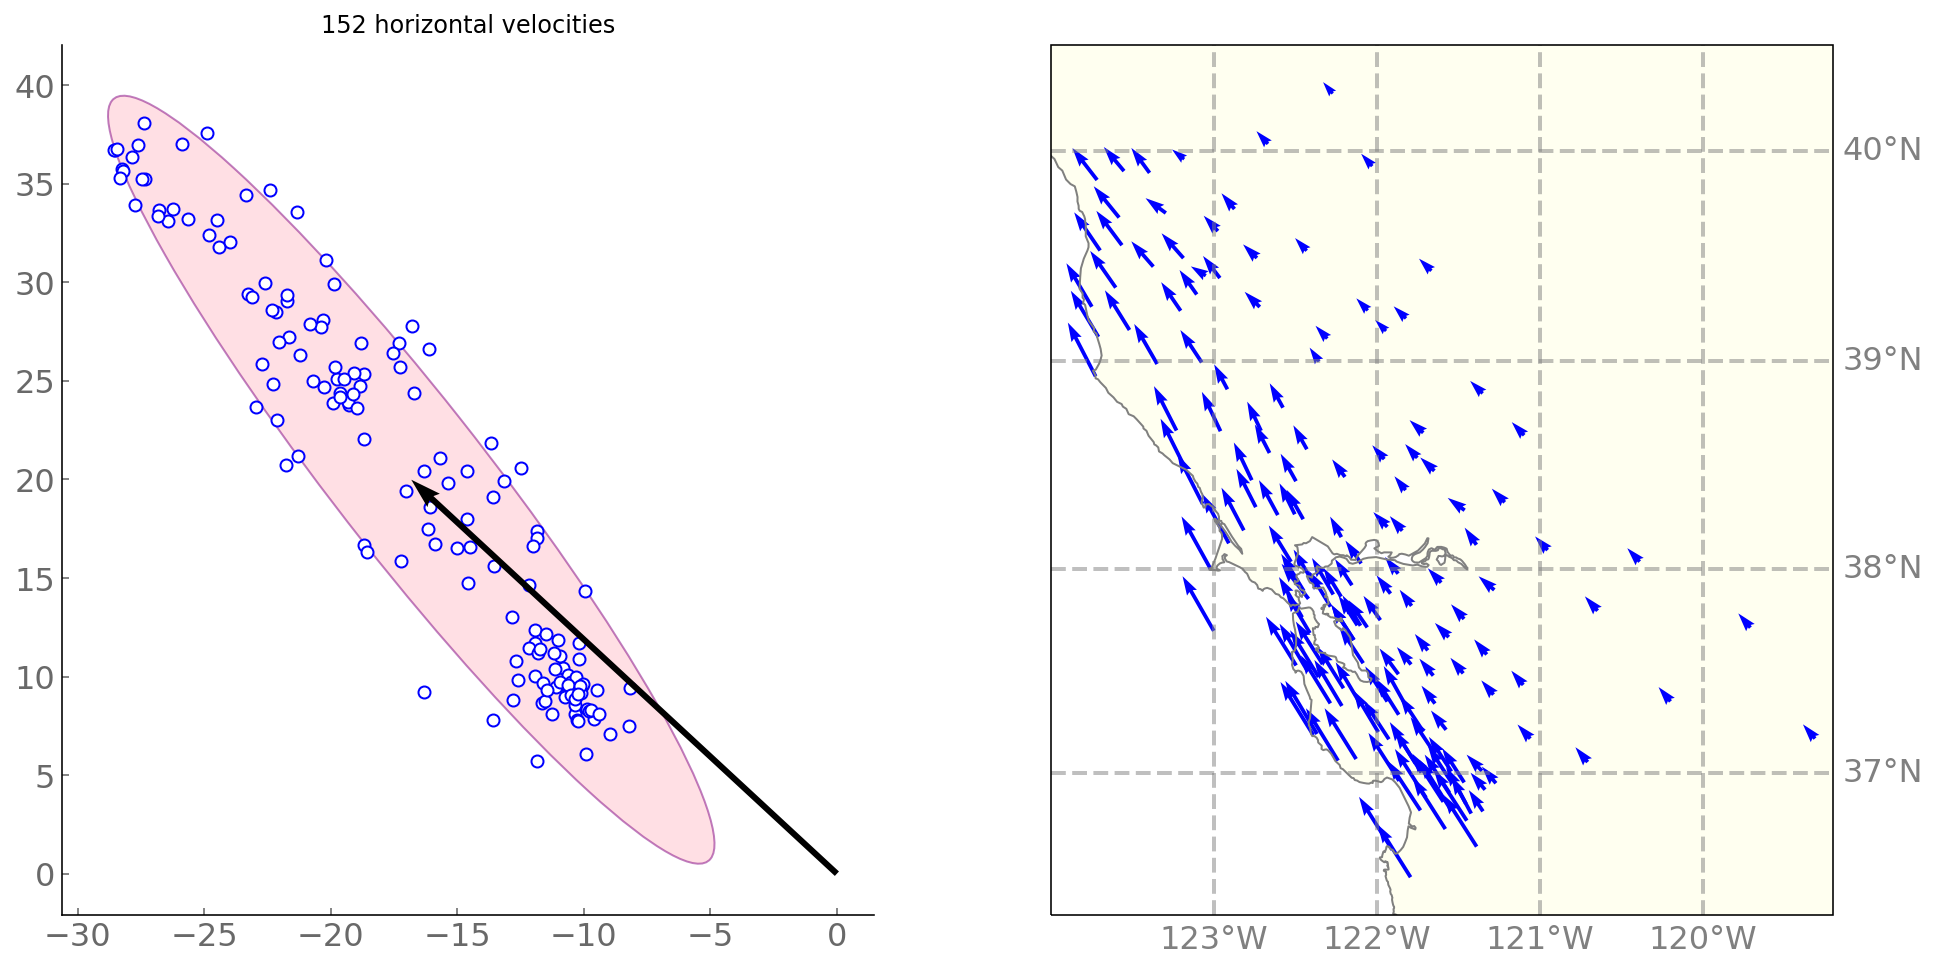

In [90]:
plot_velo_map(df_['Longitude'], df_['Latitude'], df_['Ve'], df_['Vn'])

## 2.1. Separate the locations from velocity components

In [91]:
X=df_[['Ve', 'Vn']].to_numpy()
loc=df_[['Longitude','Latitude']].to_numpy()

# 3. Clustering and robustness

In [92]:
Z = linkage(X, 'centroid', metric='euclidean') # Sanırım Simpson vd. centroid linkage kullandı

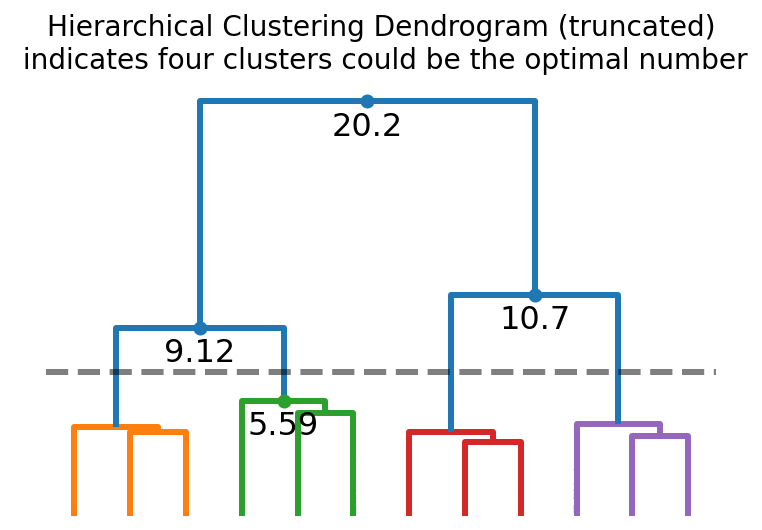

In [93]:
max_d=7
with plt.rc_context({'lines.linewidth': 3}):
    fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=14.,
    show_contracted=True,
    max_d =max_d,
    annotate_above=5,  # useful in small plots so annotations don't overlap
)
plt.show()

In [10]:
Z2 = linkage(X, 'ward', metric='euclidean') # Sanırım Simpson vd. centroid linkage kullandı

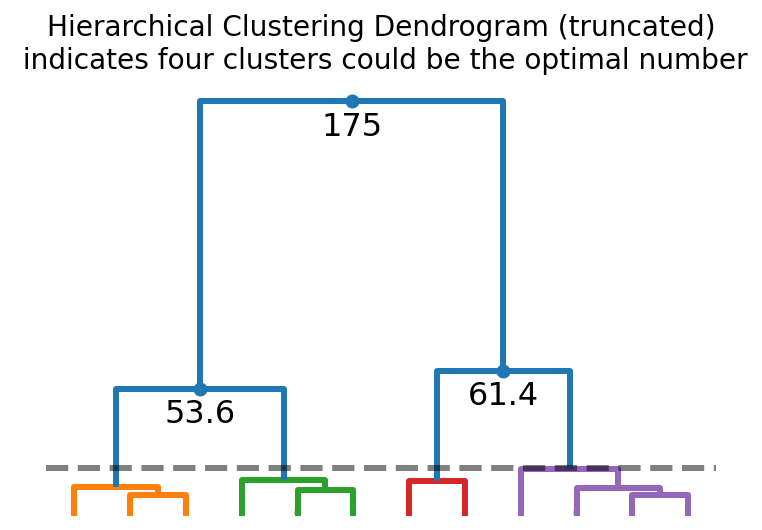

In [11]:
max_d=20
with plt.rc_context({'lines.linewidth': 3}):
    fancy_dendrogram(
    Z2,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=14.,
    show_contracted=True,
    max_d =max_d,
    annotate_above=20,  # useful in small plots so annotations don't overlap
)
plt.show()

### Explain cophonetic corrcoef. https://people.revoledu.com/kardi/tutorial/Clustering/Cophenetic.htm
82% is fairly good

In [12]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

0.8182670092482075

### Implement Tibshirani et al. 2001

<div class="alert alert-block alert-info">

> $d_{ii^\prime}$, denote the distance between observations $i$ nd $i^\prime$. The most common choice for $d_{ii^\prime}$ is the squared Euclidean distance $\sum_{ij}(x_{ij}-x_{i^\prime j})^2$. [...] Sum of pairwise distances for all points in cluster $r$:
$$D_r = \sum_{i,i^\prime \in C_r} d_{ii^\prime}$$
[and the disperson]
$$W_k = \sum_r^k \frac{1}{2n_r}D_r $$
So, if the distance $d$ is the squared Euclidean distance, then $W_k$ is the pooled within-cluster sum of squares around the cluster means (the factor 2 makes this work exactly). The sample size $n$ is suppressed in this notation.

&ndash; *Thibshirani et al. 2001*

<b>Info:</b> Therefore, I use `(cdist(X, X.mean().to_numpy().reshape(1,2))**2).sum()` instead of using
    `pdist(X.iloc[idx==n], metric='sqeuclidean').sum()`. This should significantly speed up the dispersion calculations But somehow centroid linkage in scipy implementation only works for Euclidean distance `Z = linkage(X, 'centroid', metric='euclidean')`

</div> 

In [13]:
max_cluster=10
dispersion=within_dispersion(max_cluster, Z, X) # This Wk^{obs}

### Reference data

In [14]:
U, s, Vh = linalg.svd(X) # Matlab's svd command returns U, S and V,
                         # while numpy.linalg.svd() returns U, the
                         # diagonal of S, and V^H.
V = Vh.T.conj()
xp = np.matmul(X, V)

In [15]:
bbox=[[xp[:,0].min(),xp[:,1].min()],
      [xp[:,0].min(),xp[:,1].max()],
      [xp[:,0].max(),xp[:,1].max()],
      [xp[:,0].max(),xp[:,1].min()],
      [xp[:,0].min(),xp[:,1].min()]]
bbox=np.matmul(bbox, V.T)
bbox_x, bbox_y = zip(*bbox)

dist_ref=generate_reference(xp, V)
xs, ys = zip(*dist_ref)

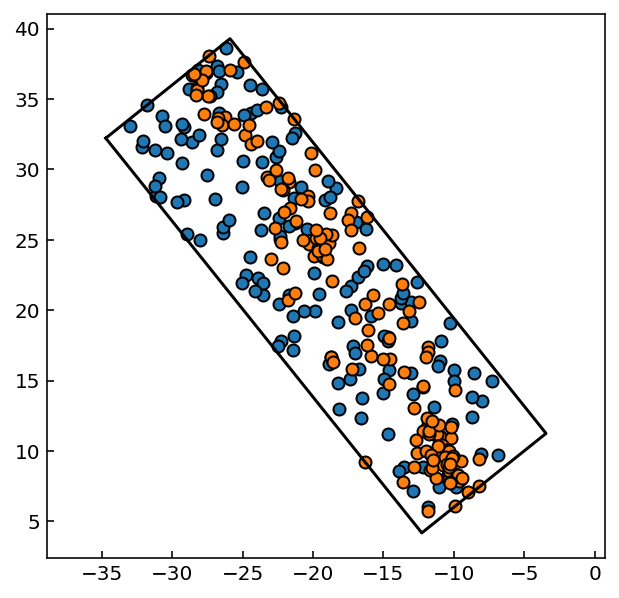

In [16]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.scatter(xs,ys, edgecolor='k')
ax.scatter(X[:,0], X[:,1], edgecolor='k')
ax.plot(bbox_x, bbox_y, c='k')

ax.tick_params(axis='both', which='both', direction='in')
ax.grid(False)
ax.axis('equal');


### Dispersion of the reference data, from B uniform distributions

In [17]:
xs_arr=np.array(xs)
ys_arr=np.array(ys)
Xref=np.concatenate([xs_arr[:,np.newaxis], ys_arr[:,np.newaxis]], axis=1)

In [18]:
max_cluster=10

repeat=20
Wref = np.zeros((repeat,max_cluster))
for i in range(repeat):
    Xref=generate_reference(xp, V)
    Zref=linkage(Xref, 'centroid')
    Wref[i,:]=within_dispersion(max_cluster, Zref, Xref)

/home/aozb/WORK/gps_cluster/src/gps_cluster/stats.py:166: RuntimeWarning: Mean of empty slice.
  [np.sum(cdist(data[idx==k], data[idx==k].mean(axis=0)[np.newaxis,:])**2)/2
/home/aozb/miniconda3/envs/gps_cluster/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


<div class="alert alert-block alert-info">

> Acounting additionally for the simulation error in $E_n^{*}\{\log W_k\}$ results in th quantity $$ s_k = \sqrt{1+1/B} \sigma(k) $$

&ndash; *Thibshirani et al. 2001*

<b>Info:</b> I initally set sd as`np.log(Wref.mean(axis=0))`

</div> 

In [19]:
sk=np.log(Wref).std(axis=0)*np.sqrt(1+1/repeat)
two_sk = 2*sk

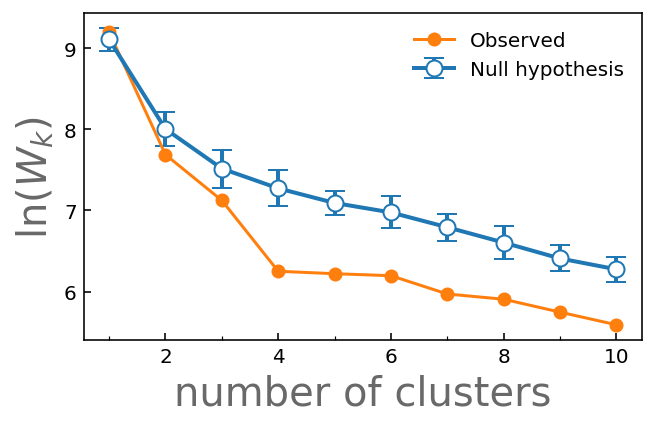

In [20]:
fig, ax = plt.subplots(figsize=(5,3))

sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
ax.errorbar(np.arange(1, max_cluster+1), np.log(Wref.mean(axis=0)), 
    yerr=two_sk,
    capsize=5, 
    fmt='-o',
    linewidth=2, 
    markerfacecolor='w',
    markersize=8,
    label='Null hypothesis')

ax.plot(np.arange(1, max_cluster+1), np.log(dispersion),
    '-o', label='Observed')

ax.set_xlabel('number of clusters', color='dimgray', fontsize=20)
ax.set_ylabel(r'$\ln(W_k)$', color='dimgray', fontsize=20)
#plt.axis('off')

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
ax.xaxis.set_minor_locator(MultipleLocator(1))
plt.legend(frameon=False)

### GAP stat

In [21]:
gap = (np.log(Wref)-np.log(dispersion)).sum(axis=0)*1/repeat

In [22]:
lbar=np.log(Wref).sum(axis=0)*1/repeat
sdk=np.sqrt(((np.log(Wref)-lbar)**2).sum(axis=0)*1/repeat)
sk=sdk*np.sqrt(1+1/repeat)

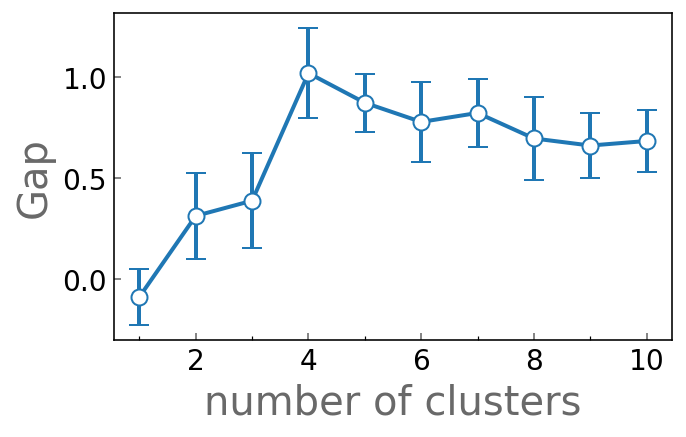

In [23]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
fig, ax = plt.subplots(figsize=(5,3))

plt.style.use(mystyle)
ax.errorbar(np.arange(1, max_cluster+1), 
    gap,
    yerr=2*sk,            
    capsize=5, 
    fmt='-o',
    linewidth=2, 
    markerfacecolor='w',
    markersize=8)

ax.set_xlabel('number of clusters', color='dimgray', fontsize=20)
ax.set_ylabel(r'Gap', color='dimgray', fontsize=20)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_formatter('{x:.1f}')
ax.tick_params(axis='both', which='major', labelsize=14, color='dimgray')

# 4. Final plot
Statistically significant, optimum numer of clusters: 4

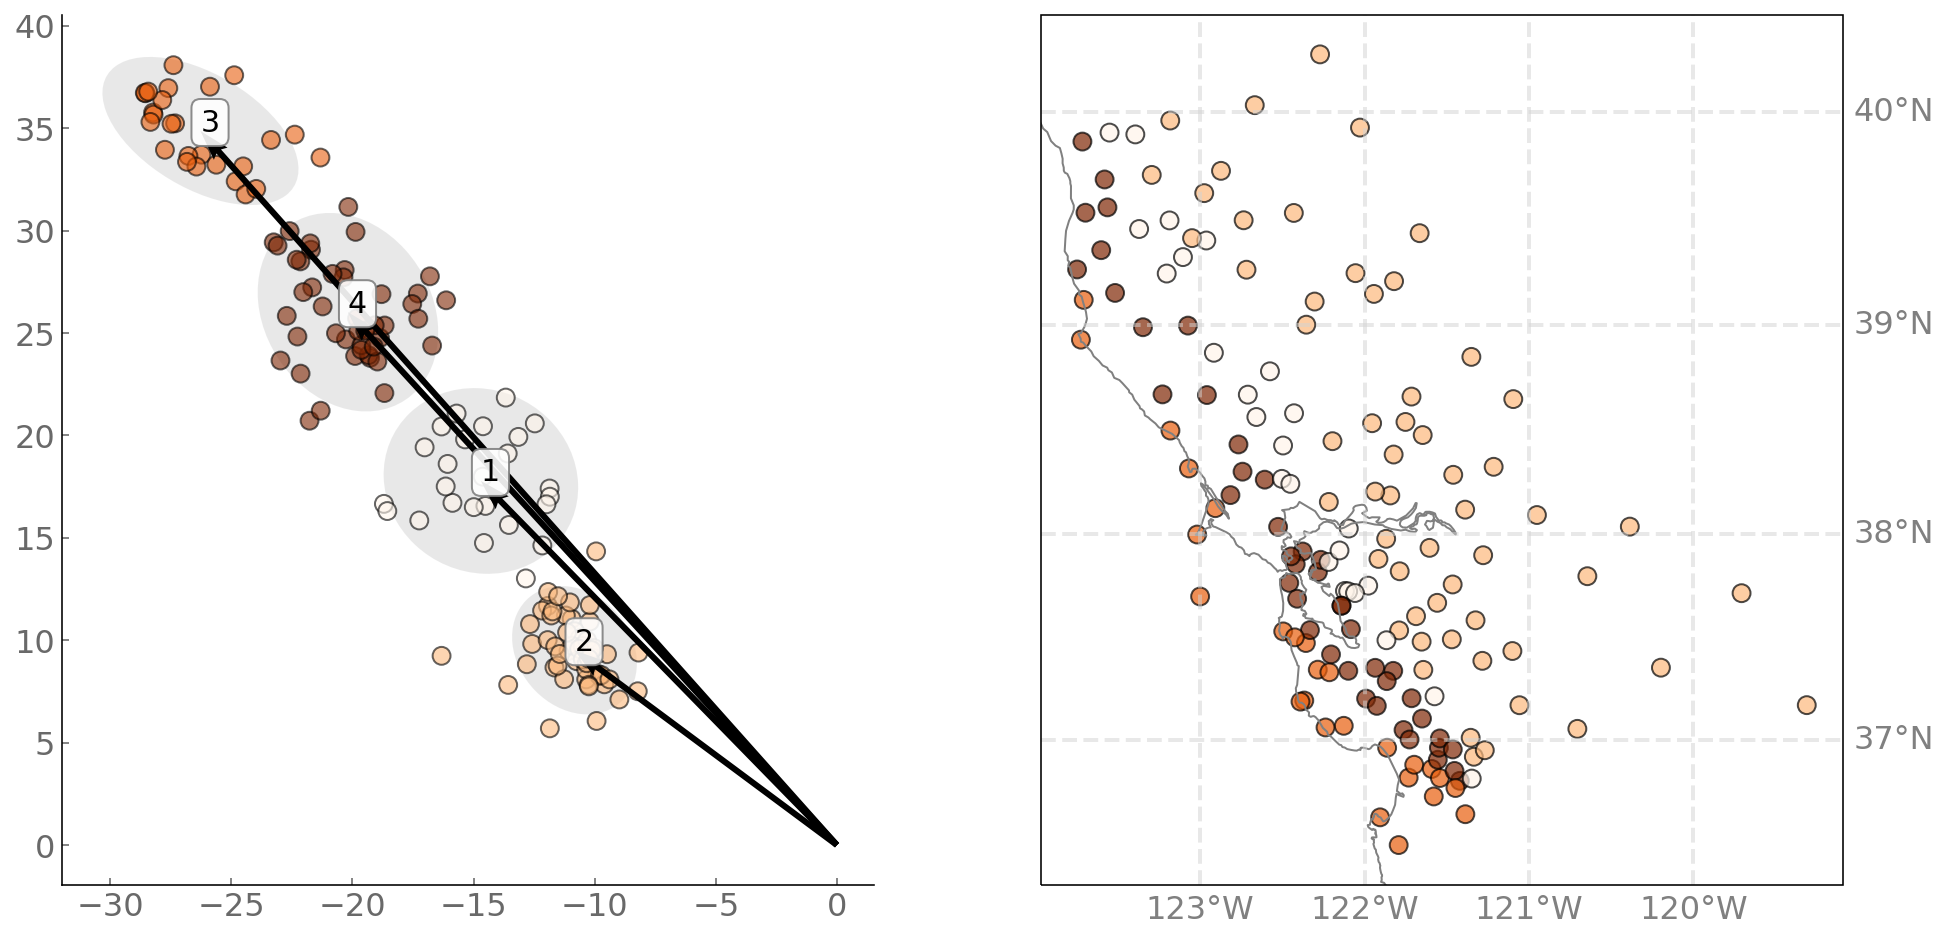

In [150]:
plot_clusters(X, loc, 4)

# 5. Calculate the Euler pole for each cluster

In [55]:
from usfEP import euler_gps, euler_pole, euler_calculate

In [94]:
# Let's start with 4 clusters
C=fcluster(Z, 4, 'maxclust')

In [95]:
df_.columns

Index(['Latitude', 'Longitude', 'Vn', 'Ve', 'Sn', 'Se', 'Corr', 'Sta', 'Vu',
       'Su'],
      dtype='object')

Let $k=1$, and we calculate the $E_{k=1}$

In [200]:
n_cluster=4
euler=np.zeros((n_cluster, 3))
for cluster in range(1, n_cluster+1):
    tmp = df_[C==cluster][['Sta', 'Longitude','Latitude', 'Ve','Vn','Vu','Se','Sn','Su']] # usfEP input format
    df_ren=tmp.rename(columns={'Longitude':'Lon', 'Latitude':'Lat', 'Se':'SigVe', 'Sn':'SigVn', 'Su':'SigVu'})
    net = euler_gps.df2network(df_ren,'X')
    pole = net.invert()
    euler[cluster-1, :] = [pole.location[0],pole.location[1],pole.velocity]

In [202]:
euler[3,:]

array([177.49752715, -24.99992838,   0.29649405])

In [230]:
lon=df_ren.iloc[0]['Lon']
lat=df_ren.iloc[0]['Lat']
[e, n, u] = euler_calculate.ll2local(lon, lat)
#print(local)
euler_calculate.vPole2local(euler[3,:], n, e, u)

Warning Vu should be 0, can not move off of sphere! Vu : -58.015959569448924


(45.40144780342438, 163.4114850496219, -58.015959569448924)

In [221]:
df_ren.iloc[0][['Lon','Lat']][0]

-122.283805

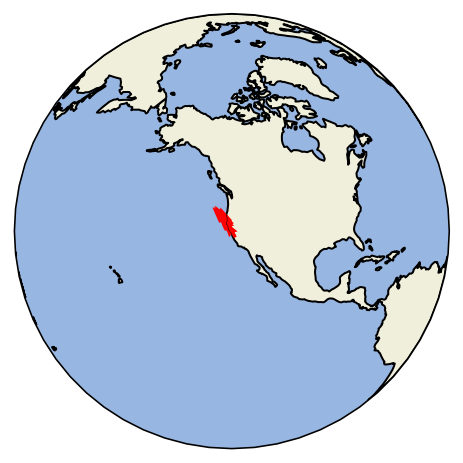

In [144]:
"

In [146]:
print ('Lat,Lon,AngV (deg/Myr) :',pole.location[1],pole.location[0],pole.velocity)

Lat,Lon,AngV (deg/Myr) : 4.6503625878728325 204.17624000981363 0.29302775851637886
